In [1]:
# 2D Toy training example
# Goal: examine how the gradients change the center and sigma of a single neuron

# version with NLL loss instead of MSE
# MSE meant I knew the target centers and sigmas were
# but NLL loss works better in general, and will have different dynamics, so worth testing

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# import sys
# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

In [5]:
# random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [7]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 2

# gaussian target parameters
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 1000

samples_xs = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
# (labels are class number)
samples_labels = np.array([ 0 if x>np.matmul(data_centers, sep_plane) else 1 for x in np.matmul(samples_xs, sep_plane)])

# shuffle in unison
permutation = np.random.permutation(len(samples_xs))
for old_index, new_index in enumerate(permutation):
    samples_xs[new_index] = samples_xs[old_index]
    samples_labels[new_index] = samples_labels[old_index]

<IPython.core.display.Javascript object>


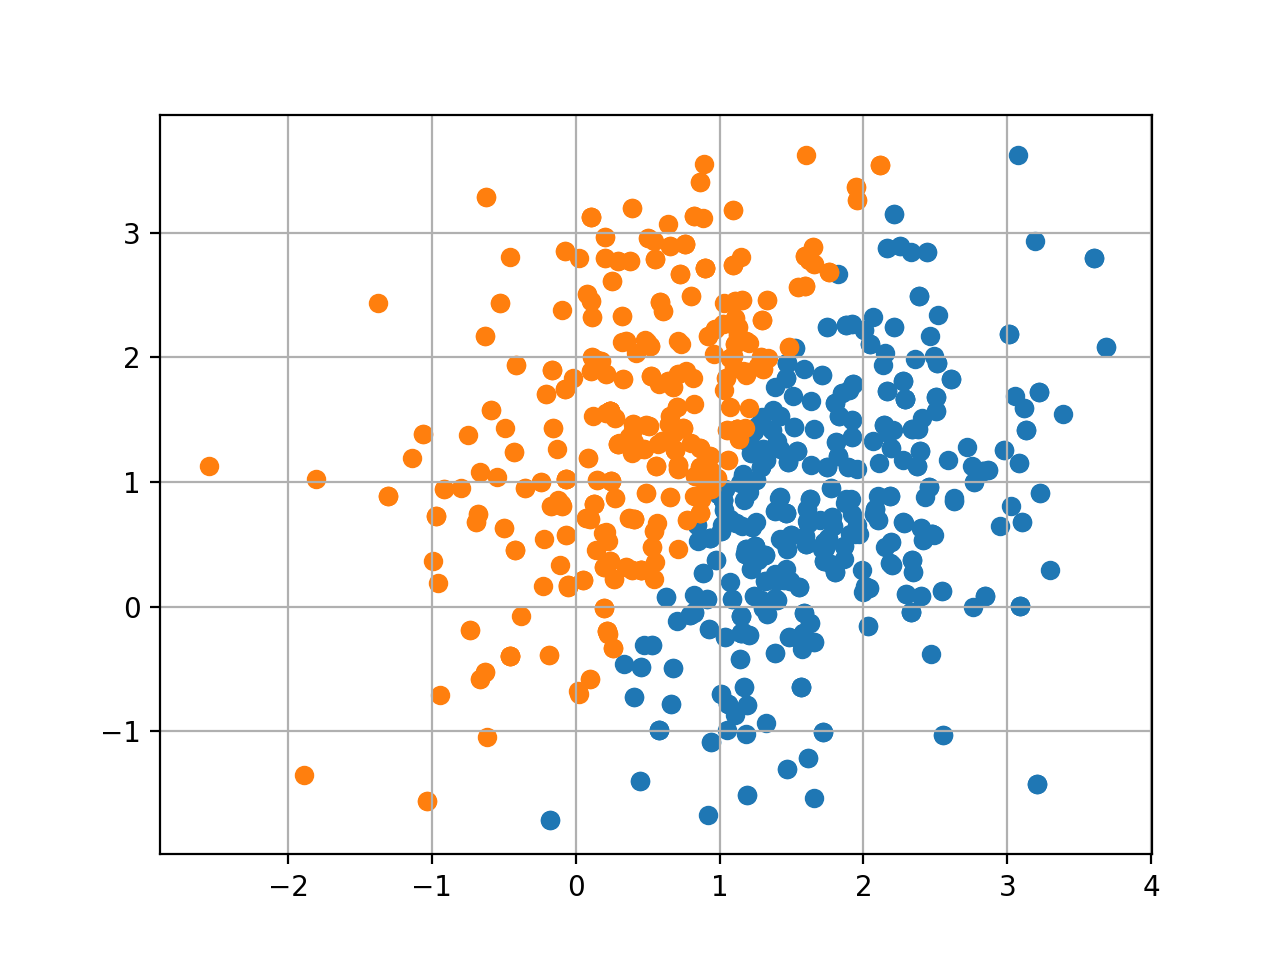

In [8]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==0]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==0]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]


plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.grid(True)
plt.show()

In [9]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [10]:
# Define a Finite Gaussian Neural Network
class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = th.FGN_layer(2,2)

    def forward(self, x):
        x,l = self.l1(x)
        x = F.softmax(x, dim=-1)
        return x,l

In [11]:
# Initialize the network
model = FGNet().to(device)

In [12]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
print("Training?", model.training) 

# check sizes
print("l1")
print(model.l1.weights.size()) 
print(model.l1.centers.size()) 
print(model.l1.sigs.size())
print(model.l1.pis.size())

# check weights before training
print("l1")
print(model.state_dict())

FGNet(
  (l1): FGN_layer()
)
[torch.Size([2, 2]), torch.Size([2, 2]), torch.Size([2]), torch.Size([2])]
Training? True
l1
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2])
l1
OrderedDict([('l1.weights', tensor([[-0.5429, -0.3697],
        [-0.0972, -0.2029]], device='cuda:0')), ('l1.centers', tensor([[-0.0092, -0.0039],
        [-0.0057, -0.0064]], device='cuda:0')), ('l1.sigs', tensor([1.9916, 1.9953], device='cuda:0')), ('l1.pis', tensor([0.5000, 0.5000], device='cuda:0'))])


In [13]:
# importances of the constraints
lmbda1 = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda1)
lmbda2 = (1.0/len(my_dataloader.dataset))
print(lmbda2)


# loss function
def loss_func(model, output, target):
    
    # split output into pred and likelihoods
    output, neg_likelihoods = output
    
    # normal NLL loss
    nll_loss = F.nll_loss(output, target.long())
    # sum of sigma squares loss
    sig_loss = lmbda1*torch.abs(model.l1.sigs).pow(2).sum()
    # negative log likelihood over gaussian loss
#     print(neg_likelihoods.shape)
    nllg_loss = torch.sum(neg_likelihoods)
    
    return 1.0*nll_loss + 1.0*sig_loss + 0.0*nllg_loss

0.0005
0.00125


In [14]:
# number of correct pred function
def pred_func(output, target):
    output,_ = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [15]:
# model_optimizer
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5, nesterov=True)

In [16]:
epochs = 300
train_res = th.train(model, device, my_dataloader, loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=pred_func, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: -0.4800, Accuracy: 336/800 (42%)
Test set - Average loss: -0.4873, Accuracy: 92/200 (46%)
Epoch 1 Train set - Average loss: -0.4848, Accuracy: 343/800 (43%)
Test set - Average loss: -0.4920, Accuracy: 92/200 (46%)
Epoch 2 Train set - Average loss: -0.4895, Accuracy: 355/800 (44%)
Test set - Average loss: -0.4966, Accuracy: 94/200 (47%)
Epoch 3 Train set - Average loss: -0.4941, Accuracy: 368/800 (46%)
Test set - Average loss: -0.5012, Accuracy: 96/200 (48%)
Epoch 4 Train set - Average loss: -0.4986, Accuracy: 385/800 (48%)
Test set - Average loss: -0.5057, Accuracy: 99/200 (50%)
Epoch 5 Train set - Average loss: -0.5032, Accuracy: 397/800 (50%)
Test set - Average loss: -0.5102, Accuracy: 101/200 (50%)
Epoch 6 Train set - Average loss: -0.5077, Accuracy: 408/800 (51%)
Test set - Average loss: -0.5147, Accuracy: 107/200 (54%)
Epoch 7 Train set - Average loss: -0.5121, Accuracy: 443/800 (55%)
Test set - Average loss: -0.5191, Accuracy: 114/200 (57%)
Epoch

Test set - Average loss: -0.7986, Accuracy: 194/200 (97%)
Epoch 66 Train set - Average loss: -0.7918, Accuracy: 763/800 (95%)
Test set - Average loss: -0.8010, Accuracy: 194/200 (97%)
Epoch 67 Train set - Average loss: -0.7941, Accuracy: 763/800 (95%)
Test set - Average loss: -0.8034, Accuracy: 194/200 (97%)
Epoch 68 Train set - Average loss: -0.7964, Accuracy: 763/800 (95%)
Test set - Average loss: -0.8057, Accuracy: 194/200 (97%)
Epoch 69 Train set - Average loss: -0.7986, Accuracy: 763/800 (95%)
Test set - Average loss: -0.8079, Accuracy: 194/200 (97%)
Epoch 70 Train set - Average loss: -0.8007, Accuracy: 762/800 (95%)
Test set - Average loss: -0.8100, Accuracy: 194/200 (97%)
Epoch 71 Train set - Average loss: -0.8028, Accuracy: 763/800 (95%)
Test set - Average loss: -0.8121, Accuracy: 194/200 (97%)
Epoch 72 Train set - Average loss: -0.8048, Accuracy: 763/800 (95%)
Test set - Average loss: -0.8141, Accuracy: 194/200 (97%)
Epoch 73 Train set - Average loss: -0.8067, Accuracy: 763/80

Test set - Average loss: -0.8743, Accuracy: 197/200 (98%)
Epoch 131 Train set - Average loss: -0.8632, Accuracy: 777/800 (97%)
Test set - Average loss: -0.8748, Accuracy: 197/200 (98%)
Epoch 132 Train set - Average loss: -0.8637, Accuracy: 777/800 (97%)
Test set - Average loss: -0.8753, Accuracy: 197/200 (98%)
Epoch 133 Train set - Average loss: -0.8642, Accuracy: 777/800 (97%)
Test set - Average loss: -0.8759, Accuracy: 197/200 (98%)
Epoch 134 Train set - Average loss: -0.8647, Accuracy: 778/800 (97%)
Test set - Average loss: -0.8764, Accuracy: 197/200 (98%)
Epoch 135 Train set - Average loss: -0.8651, Accuracy: 778/800 (97%)
Test set - Average loss: -0.8769, Accuracy: 197/200 (98%)
Epoch 136 Train set - Average loss: -0.8656, Accuracy: 778/800 (97%)
Test set - Average loss: -0.8774, Accuracy: 197/200 (98%)
Epoch 137 Train set - Average loss: -0.8661, Accuracy: 778/800 (97%)
Test set - Average loss: -0.8779, Accuracy: 197/200 (98%)
Epoch 138 Train set - Average loss: -0.8665, Accuracy

Test set - Average loss: -0.8975, Accuracy: 198/200 (99%)
Epoch 196 Train set - Average loss: -0.8846, Accuracy: 788/800 (98%)
Test set - Average loss: -0.8978, Accuracy: 198/200 (99%)
Epoch 197 Train set - Average loss: -0.8848, Accuracy: 788/800 (98%)
Test set - Average loss: -0.8980, Accuracy: 198/200 (99%)
Epoch 198 Train set - Average loss: -0.8850, Accuracy: 788/800 (98%)
Test set - Average loss: -0.8982, Accuracy: 198/200 (99%)
Epoch 199 Train set - Average loss: -0.8852, Accuracy: 788/800 (98%)
Test set - Average loss: -0.8985, Accuracy: 198/200 (99%)
Epoch 200 Train set - Average loss: -0.8854, Accuracy: 788/800 (98%)
Test set - Average loss: -0.8987, Accuracy: 198/200 (99%)
Epoch 201 Train set - Average loss: -0.8857, Accuracy: 788/800 (98%)
Test set - Average loss: -0.8989, Accuracy: 198/200 (99%)
Epoch 202 Train set - Average loss: -0.8859, Accuracy: 788/800 (98%)
Test set - Average loss: -0.8991, Accuracy: 198/200 (99%)
Epoch 203 Train set - Average loss: -0.8861, Accuracy

Test set - Average loss: -0.9094, Accuracy: 198/200 (99%)
Epoch 261 Train set - Average loss: -0.8956, Accuracy: 788/800 (98%)
Test set - Average loss: -0.9096, Accuracy: 198/200 (99%)
Epoch 262 Train set - Average loss: -0.8958, Accuracy: 788/800 (98%)
Test set - Average loss: -0.9097, Accuracy: 198/200 (99%)
Epoch 263 Train set - Average loss: -0.8959, Accuracy: 788/800 (98%)
Test set - Average loss: -0.9099, Accuracy: 198/200 (99%)
Epoch 264 Train set - Average loss: -0.8960, Accuracy: 788/800 (98%)
Test set - Average loss: -0.9100, Accuracy: 198/200 (99%)
Epoch 265 Train set - Average loss: -0.8962, Accuracy: 788/800 (98%)
Test set - Average loss: -0.9101, Accuracy: 198/200 (99%)
Epoch 266 Train set - Average loss: -0.8963, Accuracy: 788/800 (98%)
Test set - Average loss: -0.9103, Accuracy: 198/200 (99%)
Epoch 267 Train set - Average loss: -0.8964, Accuracy: 788/800 (98%)
Test set - Average loss: -0.9104, Accuracy: 198/200 (99%)
Epoch 268 Train set - Average loss: -0.8965, Accuracy

In [17]:
# test model, should be same or close to last line in above cell
th.test(model, device, my_test_dataloader, loss_func, verbose=True, pred_func=pred_func)

Test set - Average loss: -0.9144, Accuracy: 198/200 (99%)


{'test_accuracy': 99.0, 'test_loss': -0.9143527381122112}

In [18]:
# print model state_dict post training
model.state_dict()

OrderedDict([('l1.weights', tensor([[ 2.4985, -1.9293],
                      [-4.2549,  1.5463]], device='cuda:0')),
             ('l1.centers', tensor([[0.7961, 0.7407],
                      [1.0070, 0.9499]], device='cuda:0')),
             ('l1.sigs', tensor([2.9913, 3.4320], device='cuda:0')),
             ('l1.pis', tensor([0.5000, 0.5000], device='cuda:0'))])

<IPython.core.display.Javascript object>


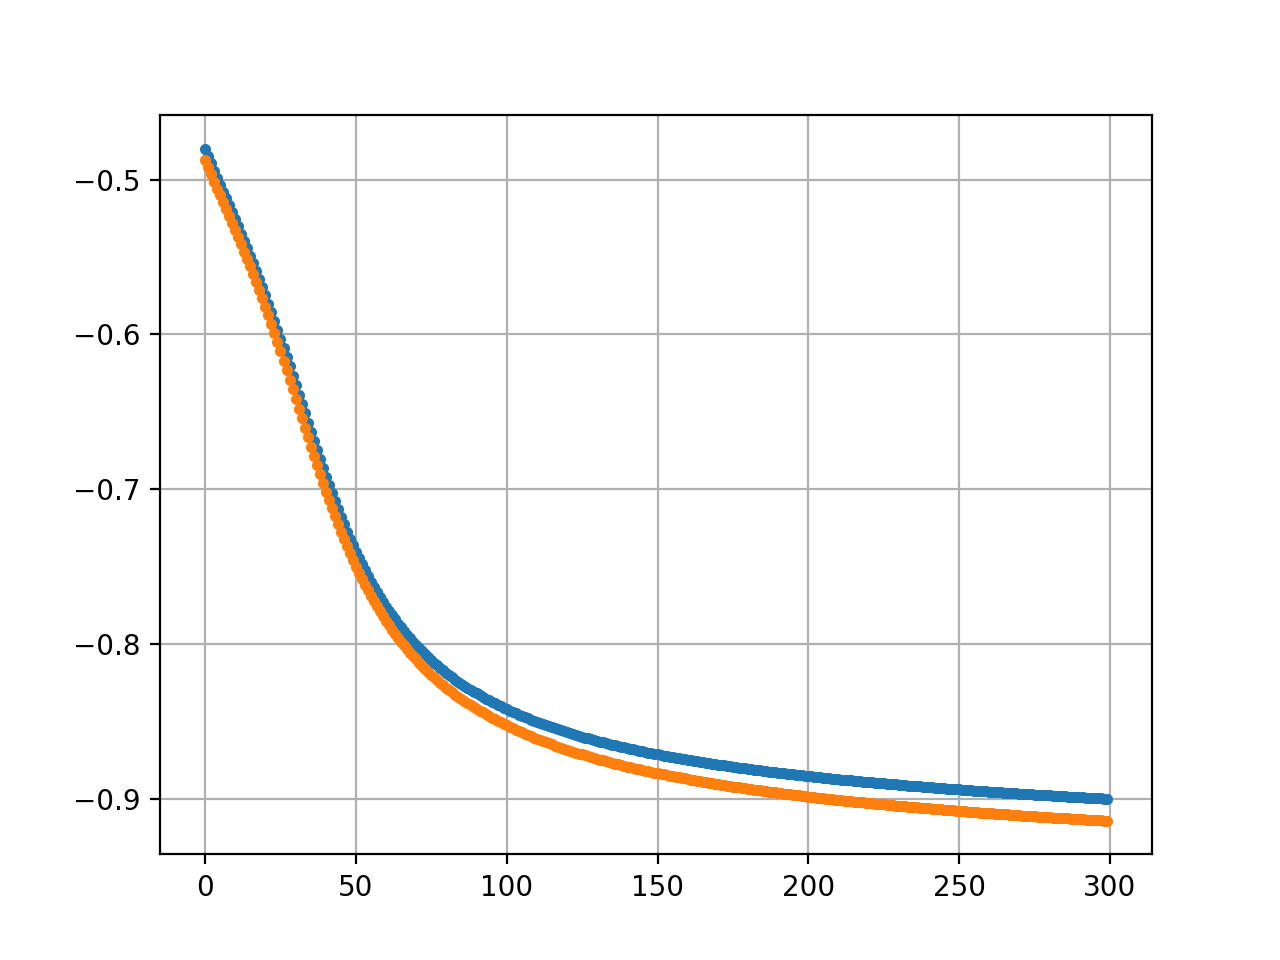

<IPython.core.display.Javascript object>


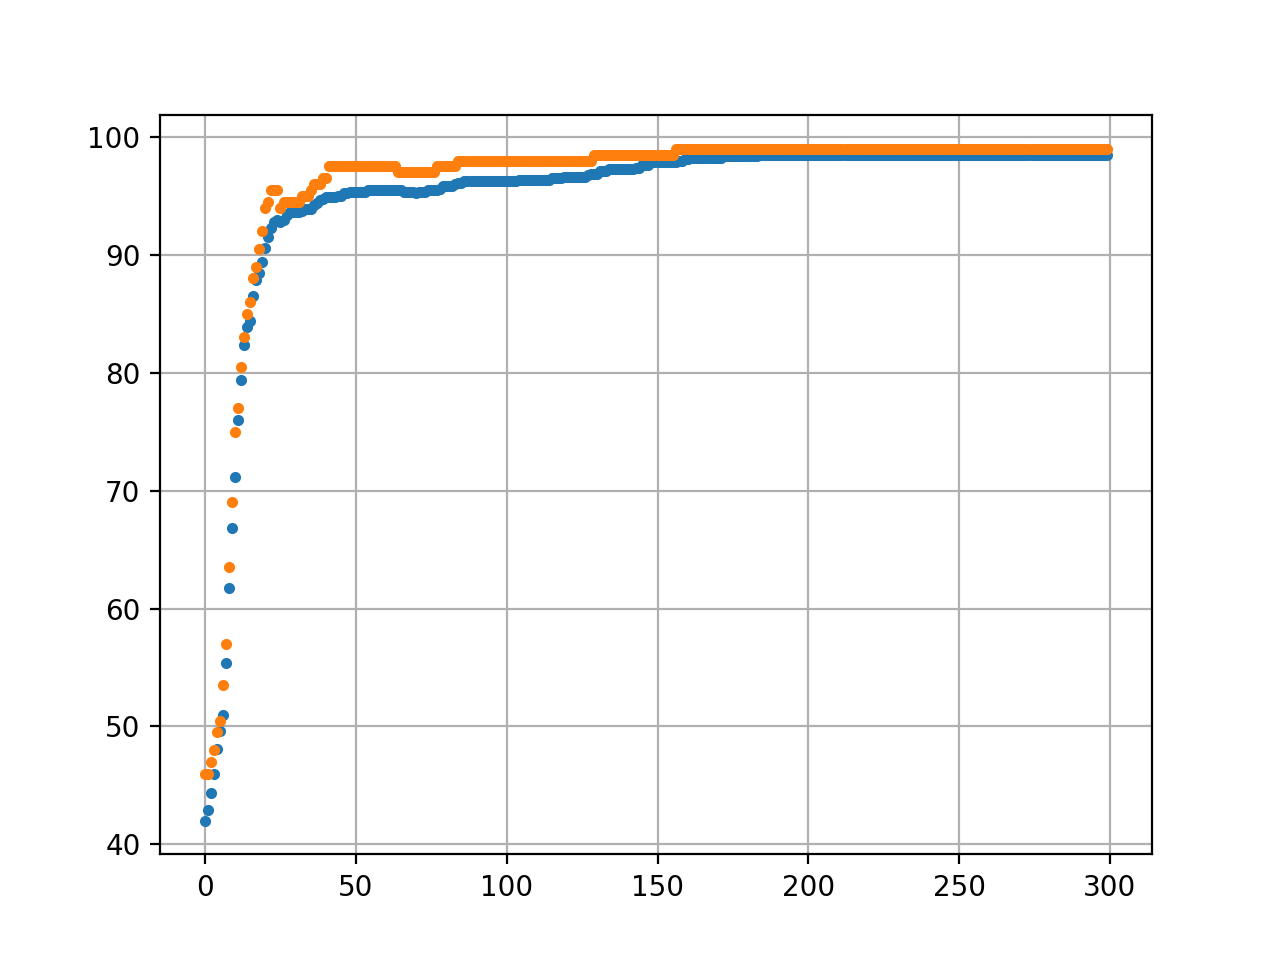

In [19]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


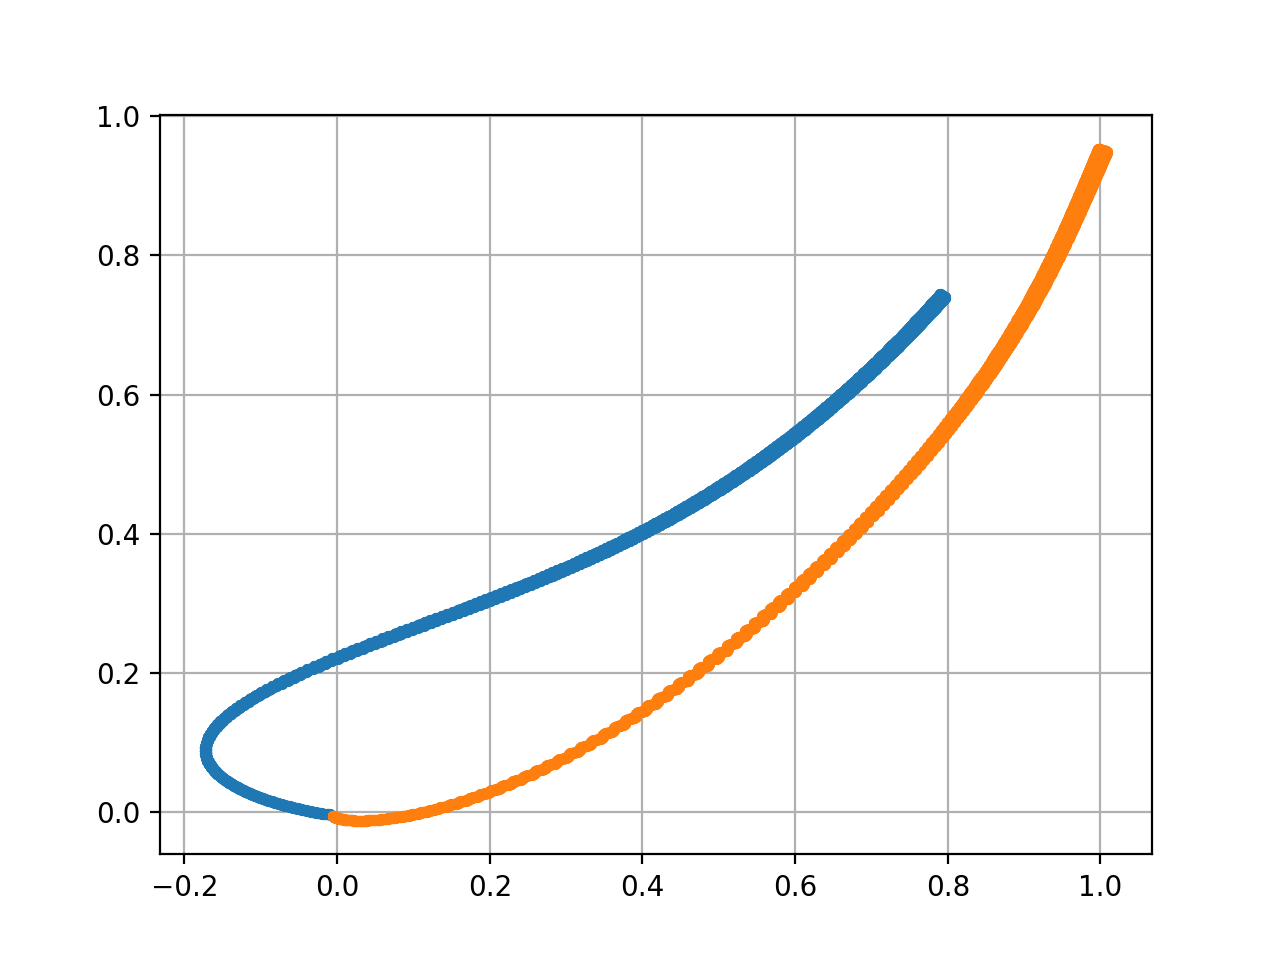

In [20]:
# compare center with target (1,1)
x, y = zip(*train_res['histories']['l1.centers'][:,0,:])
plt.plot(x,y, marker='.', linestyle='-')
x, y = zip(*train_res['histories']['l1.centers'][:,1,:])
plt.plot(x,y, marker='.', linestyle='-')
# plt.axis([-3,3, -3, 3])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


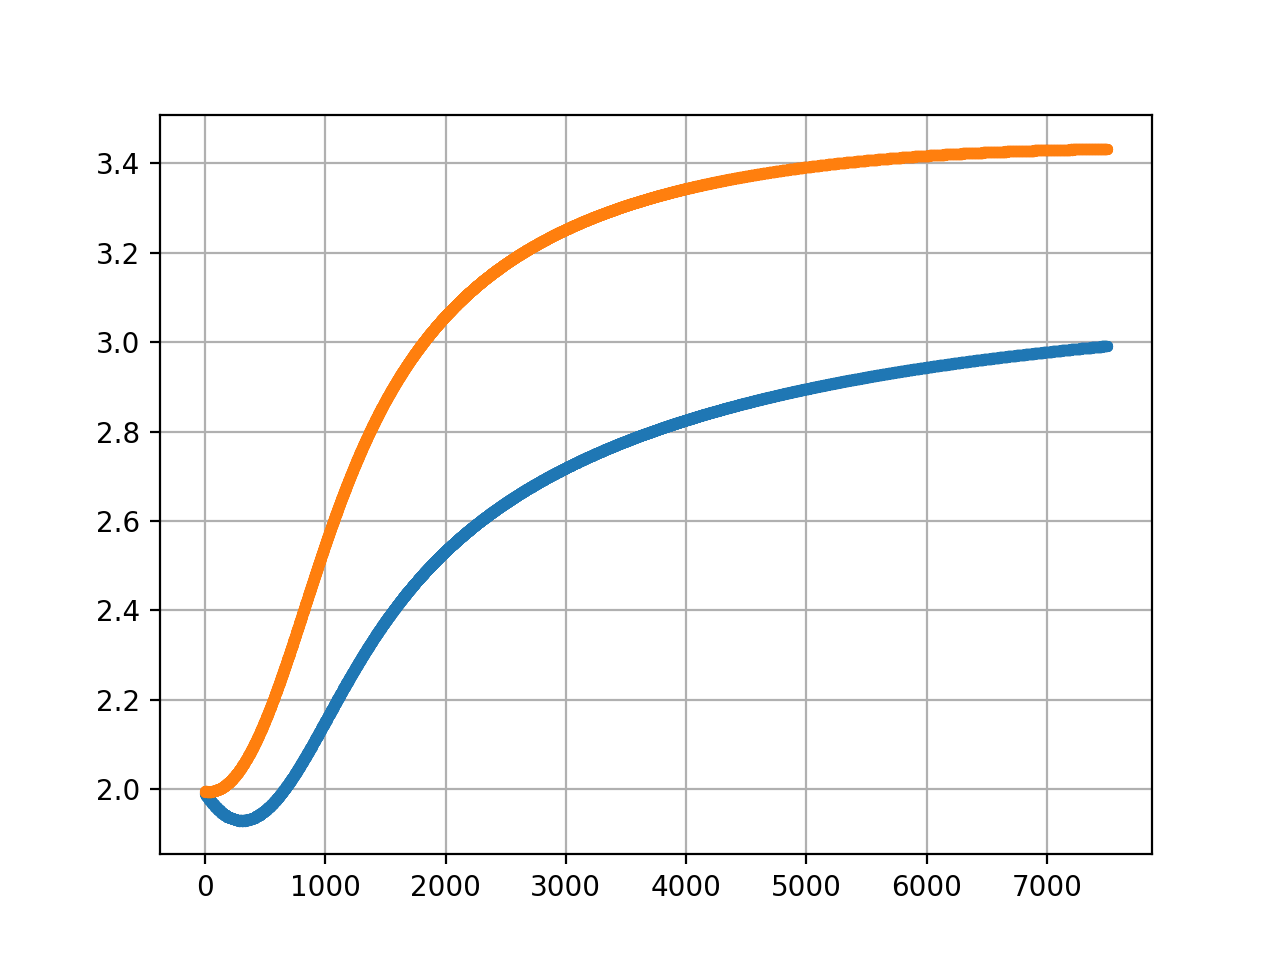

In [21]:
# plot sigma history
plt.plot(train_res['histories']['l1.sigs'][:,0], marker='.', linestyle=' ')
plt.plot(train_res['histories']['l1.sigs'][:,1], marker='.', linestyle=' ')

plt.grid()
plt.show()

In [22]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

<IPython.core.display.Javascript object>


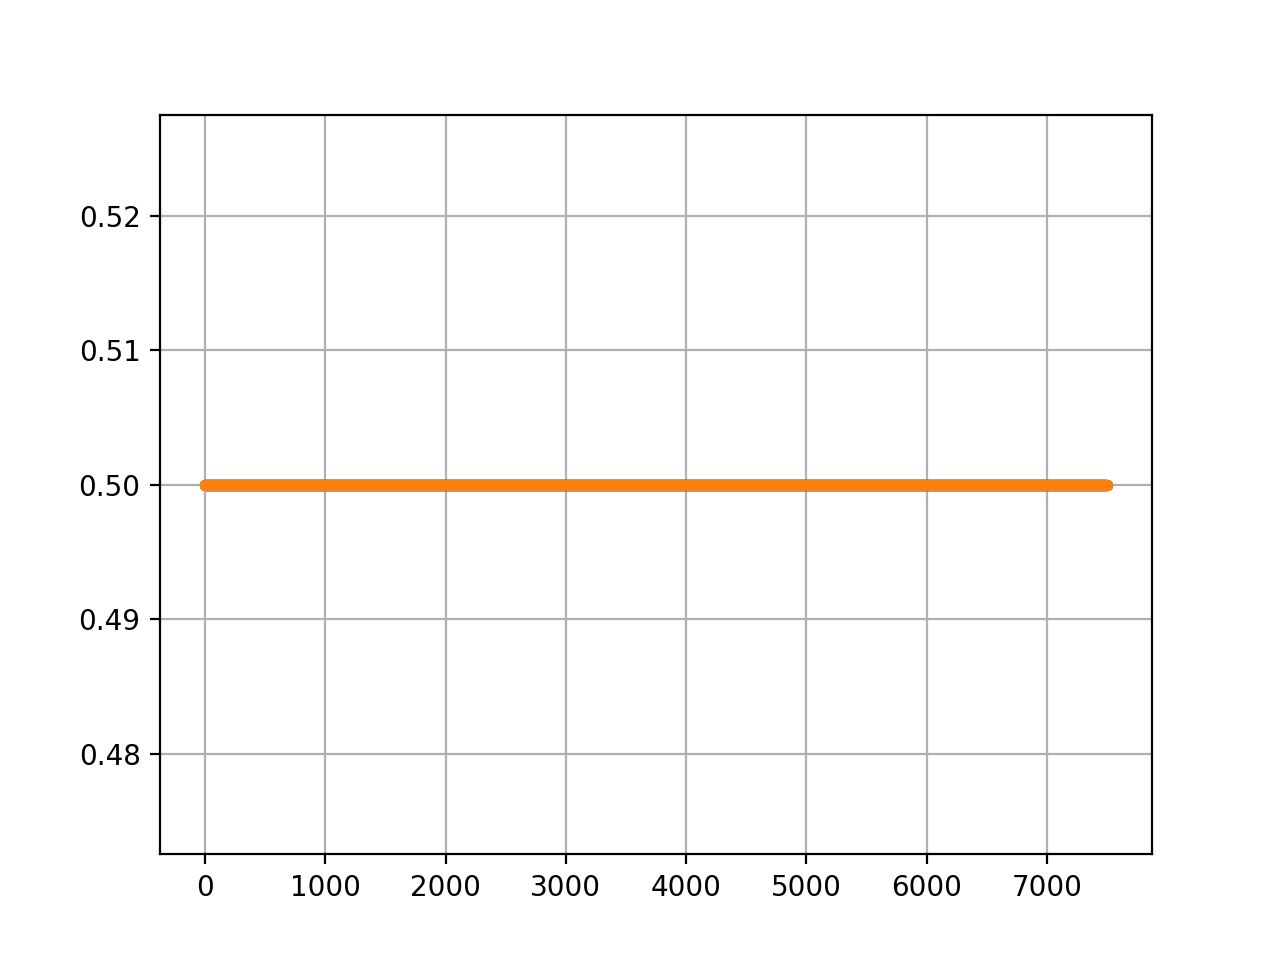

<IPython.core.display.Javascript object>


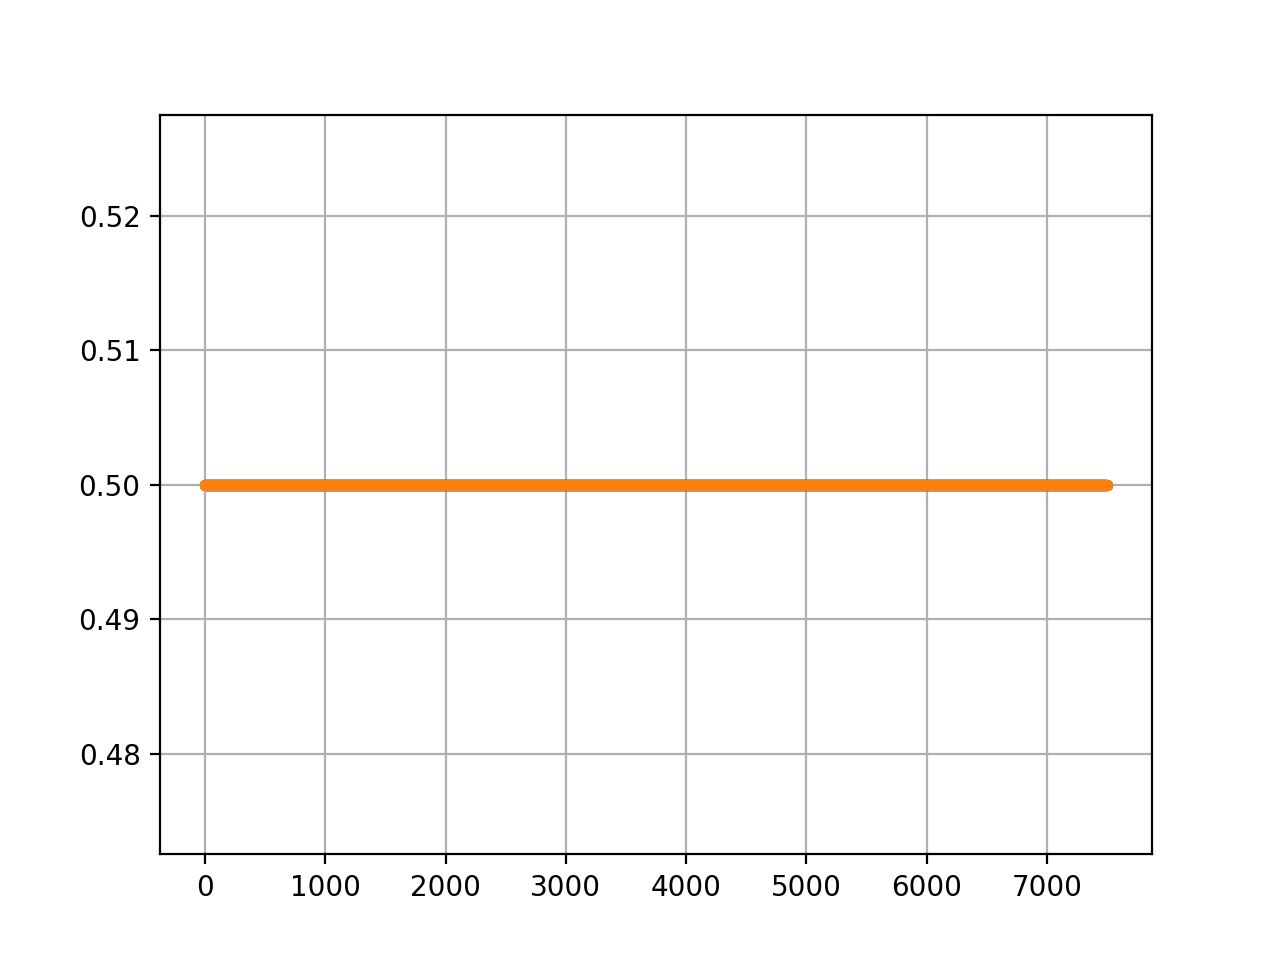

In [23]:
# plot softmax(PIs) history

# unormalized
plt.plot(train_res['histories']['l1.pis'][:,0], marker='.', linestyle=' ')
plt.plot(train_res['histories']['l1.pis'][:,1], marker='.', linestyle=' ')

plt.grid()
plt.show()

#normalized 
normalized_PIs = np.array([softmax(x) for x in train_res['histories']['l1.pis']])
plt.plot(normalized_PIs[:,0], marker='.', linestyle=' ')
plt.plot(normalized_PIs[:,1], marker='.', linestyle=' ')

plt.grid()
plt.show()